## Multiple Output Models using the Keras Functional API
we will use the Keras functional API to train a model to predict two outputs. For this simple project, we will use the **[Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)** from the **UCI machine learning repository**. It has separate datasets for red wine and white wine.

Normally, the wines are classified into one of the quality ratings specified in the attributes. In this project, we will combine the two datasets to predict the wine quality and whether the wine is red or white solely from the attributes. 

we will model wine quality estimations as a regression problem and wine type detection as a binary classification problem.

## Imports

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

In [4]:
# URL of the white wine dataset
URI = '../data/winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')

In [5]:
white_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'is_red'],
      dtype='object')

In [7]:
# URL of the red wine dataset
URI = '../data/winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')

In [8]:
red_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'is_red'],
      dtype='object')

### Concatenate the datasets

Next, concatenate the red and white wine dataframes.

In [9]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [10]:
print(df.alcohol[0])
print(df.alcohol[100])

# 9.4
# 9.5

9.4
9.5


In [11]:
# Shuffling the datset
df = df.iloc[np.random.permutation(len(df))]

This will chart the quality of the wines.

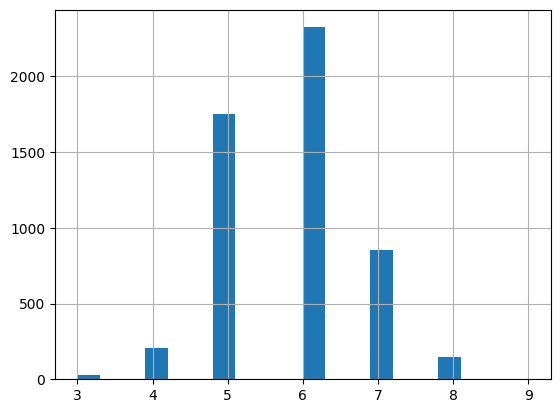

In [12]:
df['quality'].hist(bins=20);

### Imbalanced data (TODO)
You can see from the plot above that the wine quality dataset is imbalanced. 
- Since there are very few observations with quality equal to 3, 4, 8 and 9, you can drop these observations from your dataset. 
- You can do this by removing data belonging to all classes except those > 4 and < 8.

In [13]:
# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8)]

# reset index and drop the old one
df = df.reset_index(drop=True)

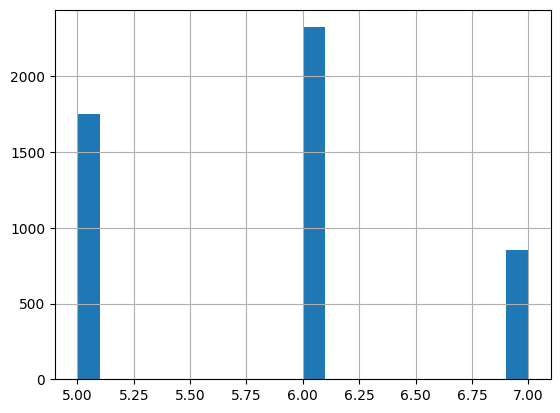

In [14]:
df['quality'].hist(bins=20);

### Train Test Split (TODO)

Next, you can split the datasets into training, test and validation datasets.
- The data frame should be split 80:20 into `train` and `test` sets.
- The resulting `train` should then be split 80:20 into `train` and `val` sets.
- The `train_test_split` parameter `test_size` takes a float value that ranges between 0. and 1, and represents the proportion of the dataset that is allocated to the test set.  The rest of the data is allocated to the training set.

In [15]:
# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

Here's where we can explore the training stats. You can pop the labels 'is_red' and 'quality' from the data as these will be used as the labels

In [16]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [17]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.207258,1.330684,4.40000,6.40000,6.90000,7.70000,15.90000
volatile acidity,3155.0,0.338645,0.160104,0.08000,0.23000,0.29000,0.41000,1.33000
citric acid,3155.0,0.320634,0.147787,0.00000,0.25000,0.31000,0.40000,1.66000
residual sugar,3155.0,5.088526,4.442820,0.60000,1.80000,2.80000,7.50000,26.05000
chlorides,3155.0,0.056460,0.035461,0.01200,0.03800,0.04700,0.06600,0.61100
free sulfur dioxide,3155.0,30.303011,17.284201,1.00000,17.00000,28.00000,41.00000,131.00000
total sulfur dioxide,3155.0,115.000000,56.279275,6.00000,76.00000,118.00000,154.00000,344.00000
density,3155.0,0.994566,0.002885,0.98711,0.99224,0.99471,0.99679,1.00369
pH,3155.0,3.224574,0.158990,2.72000,3.12000,3.22000,3.32000,4.01000
sulphates,3155.0,0.532577,0.143071,0.26000,0.44000,0.51000,0.60000,1.62000


### Get the labels

The features and labels are currently in the same dataframe.
- We will want to store the label columns `is_red` and `quality` separately from the feature columns.  
- The following function, `format_output`, gets these two columns from the dataframe.
- `format_output` also formats the data into numpy arrays. 
- We use the `format_output` and apply it to the `train`, `val` and `test` sets to get dataframes for the labels.

In [18]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [19]:
# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

Notice that after you get the labels, the `train`, `val` and `test` dataframes no longer contain the label columns, and contain just the feature columns.
- This is because we used `.pop` in the `format_output` function.

In [20]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,6.7,0.34,0.30,15.6,0.054,51.0,196.0,0.99820,3.19,0.49,9.3
3557,6.4,0.31,0.40,6.4,0.039,39.0,191.0,0.99513,3.14,0.52,9.8
3825,6.6,0.39,0.39,11.9,0.057,51.0,221.0,0.99851,3.26,0.51,8.9
1740,6.5,0.14,0.33,7.6,0.050,53.0,189.0,0.99660,3.25,0.49,8.6
1221,5.4,0.22,0.35,6.5,0.029,26.0,87.0,0.99092,3.29,0.44,12.5


### Normalize the data

In [21]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [22]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

## Define the Model

Define the model using the functional API. The base model will be 2 `Dense` layers of 128 neurons each, and have the `'relu'` activation.
- Check out the documentation for [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [23]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation=tf.nn.relu, name='base_first_dense')(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation=tf.nn.relu, name='base_second_dense')(x)
    return x

# Define output layers of the model

We will add output layers to the base model. 
- The model will need two outputs.

One output layer will predict wine quality, which is a numeric value.
- Define a `Dense` layer with 1 neuron.
- Since this is a regression output, the activation can be left as its default value `None`.

The other output layer will predict the wine type, which is either red `1` or not red `0` (white).
- Define a `Dense` layer with 1 neuron.
- Since there are two possible categories, you can use a sigmoid activation for binary classification.

Define the `Model`
- Define the `Model` object, and set the following parameters:
  - `inputs`: pass in the inputs to the model as a list.
  - `outputs`: pass in a list of the outputs that you just defined: wine quality, then wine type.
  - **Note**: we need to list the wine quality before wine type in the outputs, as this will affect the calculated loss if you choose the other order.

In [24]:
def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])

    return model

## Compiling the Model

Next, we compile the model. When setting the loss parameter of `model.compile`, we're setting the loss for each of the two outputs (wine quality and wine type).

To set more than one loss, use a dictionary of key-value pairs.

- You can look at the docs for the losses [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions).

- wine_type: Since you will be performing binary classification on wine type, you should use the binary crossentropy loss function for it.  Please pass this in as a string.  
  - **Hint**, this should be all lowercase.  In the documentation, you'll see this under the "Functions" section, not the "Classes" section.
- wine_quality: since this is a regression output, use the mean squared error.  Please pass it in as a string, all lowercase.
  - **Hint**: You may notice that there are two aliases for mean squared error.  Please use the shorter name.
 
We will also set the metric for each of the two outputs.  Again, to set metrics for two or more outputs, use a dictionary with key value pairs.
- The metrics documentation is linked [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).
- For the wine type, please set it to accuracy as a string, all lowercase.
- For wine quality, please use the root mean squared error.  Instead of a string, you'll set it to an instance of the class [RootMeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError), which belongs to the tf.keras.metrics module.

In [25]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mse',
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )

In [26]:
history = model.fit(norm_train_X, train_Y,
                    epochs = 40, validation_data=(norm_val_X, val_Y))

Epoch 1/40
99/99 [==============================] - 0s 2ms/step - loss: 4.5859 - wine_quality_loss: 4.2330 - wine_type_loss: 0.3528 - wine_quality_root_mean_squared_error: 2.0574 - wine_type_accuracy: 0.8586 - val_loss: 1.3086 - val_wine_quality_loss: 1.2115 - val_wine_type_loss: 0.0970 - val_wine_quality_root_mean_squared_error: 1.1007 - val_wine_type_accuracy: 0.9899
Epoch 2/40
99/99 [==============================] - 0s 773us/step - loss: 1.0945 - wine_quality_loss: 1.0330 - wine_type_loss: 0.0614 - wine_quality_root_mean_squared_error: 1.0164 - wine_type_accuracy: 0.9908 - val_loss: 0.7983 - val_wine_quality_loss: 0.7504 - val_wine_type_loss: 0.0479 - val_wine_quality_root_mean_squared_error: 0.8663 - val_wine_type_accuracy: 0.9911
Epoch 3/40
99/99 [==============================] - 0s 803us/step - loss: 0.7168 - wine_quality_loss: 0.6782 - wine_type_loss: 0.0386 - wine_quality_root_mean_squared_error: 0.8235 - wine_type_accuracy: 0.9921 - val_loss: 0.5985 - val_wine_quality_loss: 

In [27]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')


25/25 [==============================] - 0s 706us/step - loss: 0.3889 - wine_quality_loss: 0.3564 - wine_type_loss: 0.0325 - wine_quality_root_mean_squared_error: 0.5970 - wine_type_accuracy: 0.9975

loss: 0.388884961605072
wine_quality_loss: 0.35639363527297974
wine_type_loss: 0.032491251826286316
wine_quality_rmse: 0.5969871282577515
wine_type_accuracy: 0.9974651336669922


## Analyze the Model Performance

Note that the model has two outputs. The output at index 0 is quality and index 1 is wine type

So, round the quality predictions to the nearest integer.

In [28]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

31/31 [==============================] - 0s 530us/step


In [30]:
print(quality_pred[0])

[5.717078]


In [31]:
print(type_pred[0])
print(type_pred[944])

[0.00014616]
[6.037735e-05]


### Plot Utilities

We define a few utilities to visualize the model performance.

In [32]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [33]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(test_Y[1], np.round(type_pred), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot(values_format='d');

def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

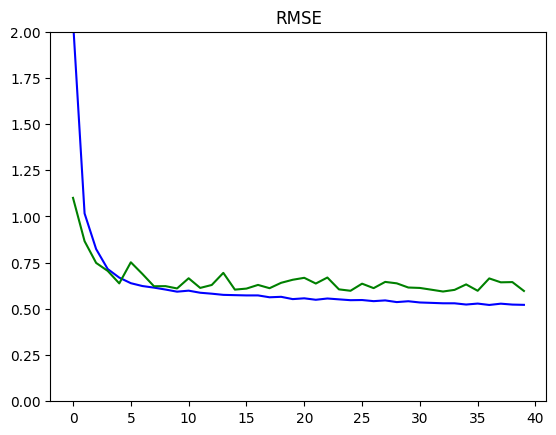

In [34]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

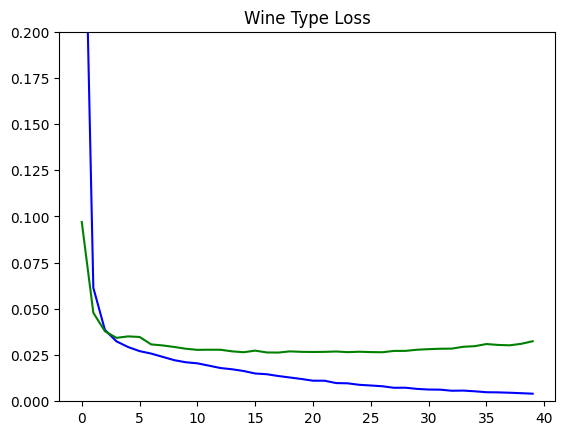

In [35]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix

Plot the confusion matrices for wine type. You can see that the model performs well for prediction of wine type from the confusion matrix and the loss metrics.

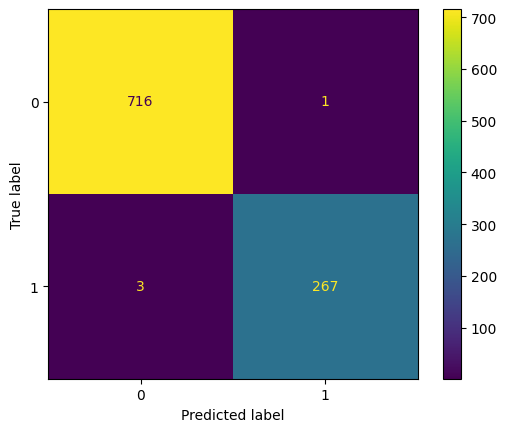

In [36]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])